In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
from matplotlib import cm

from graspologic.embed import AdjacencySpectralEmbed, select_dimension
from graspologic.align import SeedlessProcrustes, SignFlips
from graspologic.plot import heatmap

from utils import load_data

%matplotlib inline

<AxesSubplot:title={'center':'Right'}>

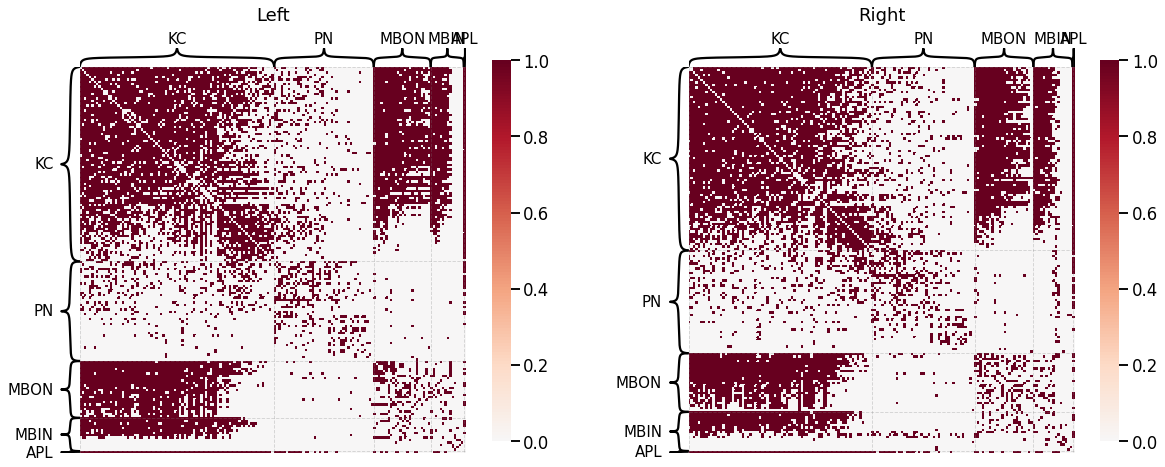

In [2]:
A_l, nodes_l, A_r, nodes_r, hemispheres = load_data()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
heatmap(A_l, inner_hier_labels=nodes_l, hier_label_fontsize=15, sort_nodes=True, ax=ax[0], title="Left")
heatmap(A_r, inner_hier_labels=nodes_r, hier_label_fontsize=15, sort_nodes=True, ax=ax[1], title="Right")

In [3]:
num_dims1 = select_dimension(A_l)[0][-1]
num_dims2 = select_dimension(A_r)[0][-1]
n_components = max(num_dims1, num_dims2)

print(n_components)

3


In [4]:
ase = AdjacencySpectralEmbed(n_components=n_components, algorithm='full', diag_aug=True, check_lcc=False)
X1_hat = ase.fit_transform(A_l)
X2_hat = ase.fit_transform(A_r)

X1_opt = SeedlessProcrustes().fit_transform(X1_hat, X2_hat)
X1_median = SignFlips(criterion="median").fit_transform(X1_hat, X2_hat)

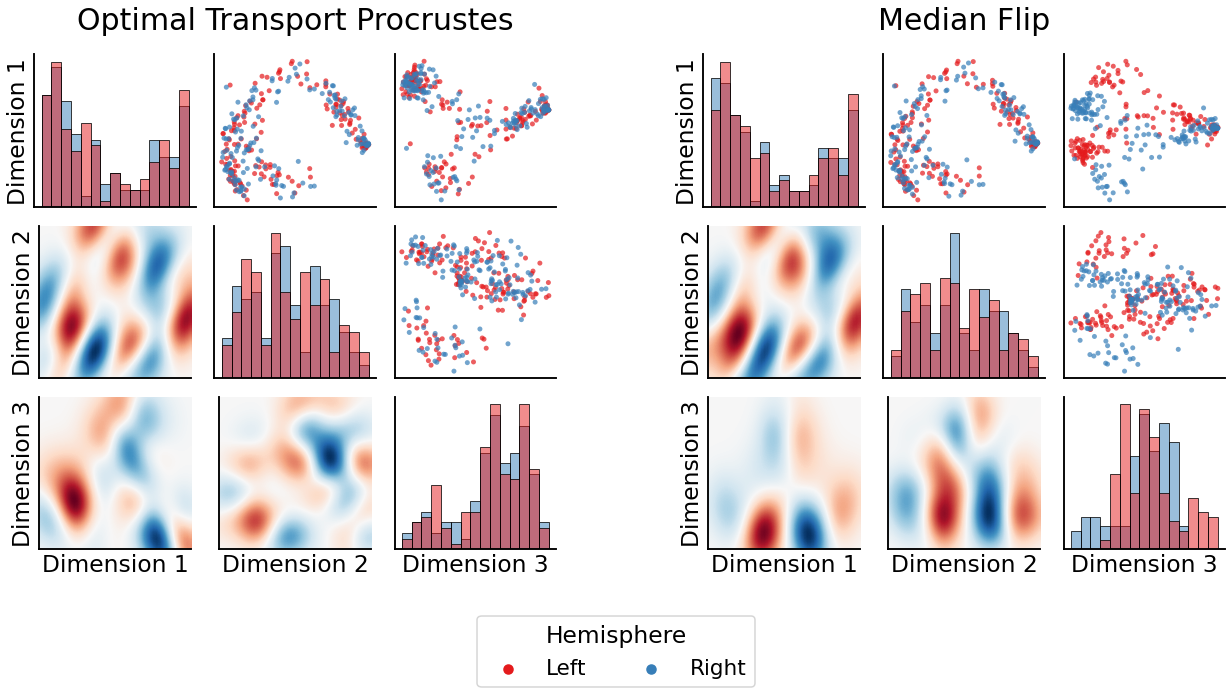

In [5]:
sns.set_context("talk", 1.3)

labels = X1_hat.shape[0] * ["Left"] + X2_hat.shape[0] * ["Right"]
bw_method = 0.4

fig, ax = plt.subplots(3, 7, constrained_layout=True, figsize=(17, 8), gridspec_kw=dict(width_ratios=[1, 1, 1, .625, 1, 1, 1]))

for row in range(3):
    for col in range(3):
        if row == col:
            x = np.hstack([X1_opt[:, row], X2_hat[:, col]])
            tmp_df = pd.DataFrame()
            tmp_df["values"] = x
            tmp_df["labels"] = labels
            sns.histplot(data = tmp_df, x="values", hue="labels", ax = ax[row, col], palette="Set1", bins=15, legend=False)

        elif row < col:
            data = np.vstack([X1_opt[:, (row, col)], X2_hat[:, (row, col)]])
            tmp_df = pd.DataFrame(data, columns=["x", "y"])
            tmp_df["labels"] = labels
            sns.scatterplot(data=tmp_df,x="x", y="y", hue="labels", ax=ax[row, col], palette="Set1", alpha=0.7, linewidth=0, marker=".", s=100)
            
            leg = ax[row, col].get_legend_handles_labels() 
            ax[row, col].legend().remove()

        elif row > col:
            x = X1_opt[:, (row, col)]
            y = X2_hat[:, (row, col)]
            X1_kde = scipy.stats.gaussian_kde(x.T, bw_method)
            X2_kde = scipy.stats.gaussian_kde(y.T, bw_method)

            # get domains
            domains = []
            for i in range(2):
                min_x = x[:, i].min()
                min_y = y[:, i].min()
                min_ = np.min((min_x, min_y))
                
                max_x = x[:, i].max()
                max_y = y[:, i].max()
                max_ = np.max((max_x, max_y))
                
                domain = (min_, max_) 
                domains.append(np.linspace(*domain, 50))
                
            X, Y = np.meshgrid(domains[0], domains[1])

            X1_pdf =  np.array([X1_kde.pdf(point) for point in zip(np.ravel(X), np.ravel(Y))]).reshape(50, 50)
            X2_pdf =  np.array([X2_kde.pdf(point) for point in zip(np.ravel(X), np.ravel(Y))]).reshape(50, 50)
            
            Z = X1_pdf - X2_pdf
            im = ax[row, col].imshow(Z, interpolation='bilinear', cmap=cm.RdBu_r,
                           origin='lower',
                           vmax=abs(Z).max(), vmin=-abs(Z).max())
            
        ax[row, col].spines['right'].set_visible(False)
        ax[row, col].spines['top'].set_visible(False)
        
        ax[row, col].axes.xaxis.set_ticks([])
        ax[row, col].axes.yaxis.set_ticks([])
        
        if col == 0:
            ax[row, col].set_ylabel(f"Dimension {row + 1}")
        else:
            ax[row, col].set_ylabel("")
        
        if row == 2:
            ax[row, col].set_xlabel(f"Dimension {col + 1}")
        else:
            ax[row, col].set_xlabel("")

for row in range(3):
    for col in range(4, 7):
        if row == (col - 1) % 3:
            x = np.hstack([X1_median[:, row % 3], X2_hat[:, (col - 1) % 3]])
            tmp_df = pd.DataFrame()
            tmp_df["values"] = x
            tmp_df["labels"] = labels
            sns.histplot(data = tmp_df, x="values", hue="labels", ax = ax[row, col], palette="Set1", bins=15, legend=False)

        elif row < (col - 1) % 3:
            data = np.vstack([X1_median[:, (row % 3, col % 3 - 1)], X2_hat[:, (row % 3, (col - 1) % 3)]])
            tmp_df = pd.DataFrame(data, columns=["x", "y"])
            tmp_df["labels"] = labels
            sns.scatterplot(data=tmp_df,x="x", y="y", hue="labels", ax=ax[row, col], palette="Set1", alpha=0.7, linewidth=0, marker=".", s=100)
            
            leg = ax[row, col].get_legend_handles_labels() 
            ax[row, col].legend().remove()

        elif row > (col - 1) % 3:
            x = X1_median[:, (row % 3, (col - 1) % 3)]
            y = X2_hat[:, (row % 3, (col - 1) % 3)]
            X1_kde = scipy.stats.gaussian_kde(x.T, bw_method)
            X2_kde = scipy.stats.gaussian_kde(y.T, bw_method)
            
            
            # get domains
            domains = []
            
            for i in range(2):
                min_x = x[:, i].min()
                min_y = y[:, i].min()
                min_ = np.min((min_x, min_y))
                
                max_x = x[:, i].max()
                max_y = y[:, i].max()
                max_ = np.max((max_x, max_y))
                
                domain = (min_, max_) 
                domains.append(np.linspace(*domain, 50))
                
            X, Y = np.meshgrid(domains[0], domains[1])

            X1_pdf =  np.array([X1_kde.pdf(point) for point in zip(np.ravel(X), np.ravel(Y))]).reshape(50, 50)
            X2_pdf =  np.array([X2_kde.pdf(point) for point in zip(np.ravel(X), np.ravel(Y))]).reshape(50, 50)
            
            Z = X1_pdf - X2_pdf
            im = ax[row, col].imshow(Z, interpolation='bilinear', cmap=cm.RdBu_r,
                           origin='lower',
                           vmax=abs(Z).max(), vmin=-abs(Z).max())
            
            
        ax[row, col].spines['right'].set_visible(False)
        ax[row, col].spines['top'].set_visible(False)
        
        ax[row, col].axes.xaxis.set_ticks([])
        ax[row, col].axes.yaxis.set_ticks([])
        
        if col == 4:
            ax[row, col].set_ylabel(f"Dimension {row + 1}")
        else:
            ax[row, col].set_ylabel("")
        
        if row == 2:
            ax[row, col].set_xlabel(f"Dimension {(col - 1) % 3 + 1}")
        else:
            ax[row, col].set_xlabel("")

for i in range(3):
    ax[i, 3].set_axis_off()
    
ax[0, 1].set_title("Optimal Transport Procrustes", fontsize=30, pad=25)
ax[0, -2].set_title("Median Flip", fontsize=30, pad=25)

handles, labels = leg

legend = fig.legend(
    handles=handles,
    labels=labels,
    ncol = 2, 
    loc='center',
    bbox_to_anchor=(.5, -.125),
    bbox_transform=plt.gcf().transFigure,
    title = "Hemisphere"
)

In [6]:
fig.savefig("./figures/figure3.pdf", dpi=300, bbox_inches="tight")
fig.savefig("./figures/figure3.png", dpi=300, bbox_inches="tight")